
IMDb Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Poster_Link    1000 non-null   object 
 1   Series_Title   1000 non-null   object 
 2   Released_Year  1000 non-null   object 
 3   Certificate    899 non-null    object 
 4   Runtime        1000 non-null   object 
 5   Genre          1000 non-null   object 
 6   IMDB_Rating    1000 non-null   float64
 7   Overview       1000 non-null   object 
 8   Meta_score     843 non-null    float64
 9   Director       1000 non-null   object 
 10  Star1          1000 non-null   object 
 11  Star2          1000 non-null   object 
 12  Star3          1000 non-null   object 
 13  Star4          1000 non-null   object 
 14  No_of_Votes    1000 non-null   int64  
 15  Gross          831 non-null    object 
dtypes: float64(2), int64(1), object(13)
memory usage: 125.1+ KB
None
                 

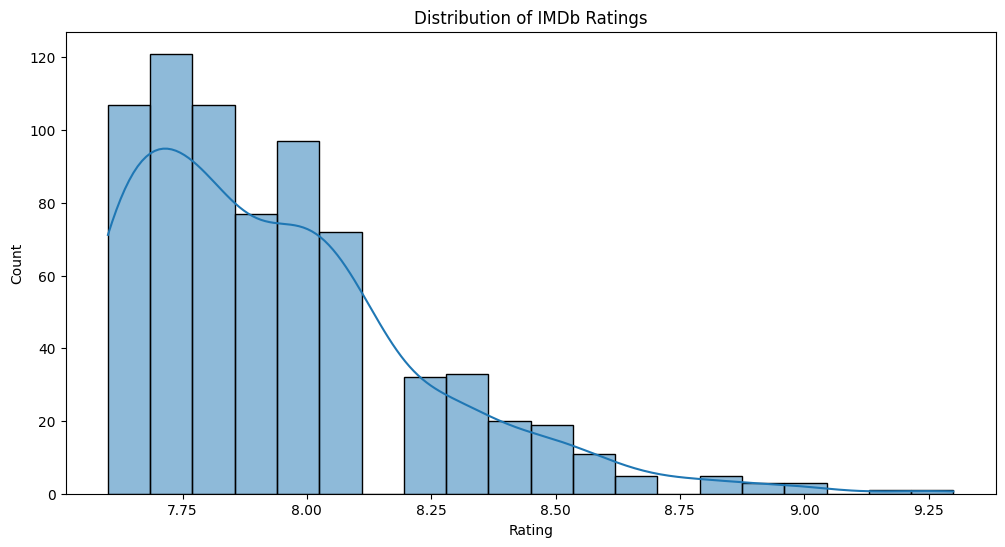

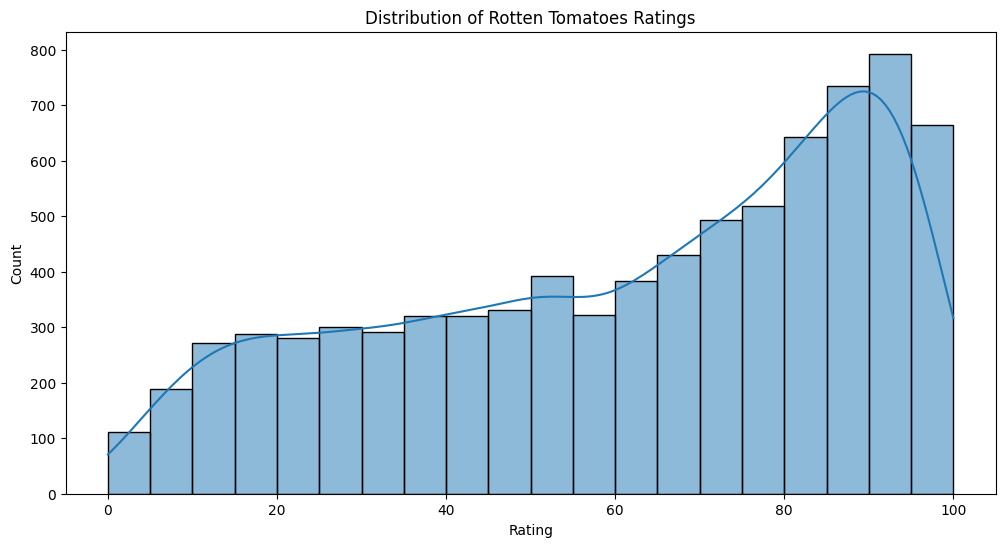

Data processing complete. Cleaned files saved.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
imdb_df = pd.read_csv('../Data/imdb_top_1000.csv')
netflix_df = pd.read_csv('../Data/netflix_titles.csv')
rotten_reviews_df = pd.read_csv('../Data/rotten_tomatoes_critic_reviews.csv')
tmdb_credits_df = pd.read_csv('../Data/tmdb_5000_credits.csv')
rotten_movies_df = pd.read_csv('../Data/rotten_tomatoes_movies.csv')

# Display basic info for each dataset
def explore_data(df, name):
    print(f"\n{name} Dataset:")
    print(df.info())
    print(df.head())
    print("Missing values:")
    print(df.isnull().sum())
    print("-" * 50)

explore_data(imdb_df, "IMDb")
explore_data(netflix_df, "Netflix")
explore_data(rotten_reviews_df, "Rotten Tomatoes Reviews")
explore_data(tmdb_credits_df, "TMDB Credits")
explore_data(rotten_movies_df, "Rotten Tomatoes Movies")

# Handle missing values
imdb_df.dropna(inplace=True)
netflix_df.dropna(inplace=True)
rotten_reviews_df.dropna(inplace=True)
tmdb_credits_df.dropna(inplace=True)
rotten_movies_df.dropna(inplace=True)

# Remove duplicates
imdb_df.drop_duplicates(inplace=True)
netflix_df.drop_duplicates(inplace=True)
rotten_reviews_df.drop_duplicates(inplace=True)
tmdb_credits_df.drop_duplicates(inplace=True)
rotten_movies_df.drop_duplicates(inplace=True)

# Basic visualizations
plt.figure(figsize=(12, 6))
sns.histplot(imdb_df['IMDB_Rating'], bins=20, kde=True)
plt.title("Distribution of IMDb Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(rotten_movies_df['tomatometer_rating'], bins=20, kde=True)
plt.title("Distribution of Rotten Tomatoes Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

# Save cleaned data
imdb_df.to_csv('cleaned_imdb.csv', index=False)
netflix_df.to_csv('cleaned_netflix.csv', index=False)
rotten_reviews_df.to_csv('cleaned_rotten_reviews.csv', index=False)
tmdb_credits_df.to_csv('cleaned_tmdb_credits.csv', index=False)
rotten_movies_df.to_csv('cleaned_rotten_movies.csv', index=False)

print("Data processing complete. Cleaned files saved.")


In [3]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from scipy import stats

# Load datasets
rt_movies = pd.read_csv("../Data/rotten_tomatoes_movies.csv")
rt_reviews = pd.read_csv("../Data/rotten_tomatoes_critic_reviews.csv")
netflix = pd.read_csv("../Data/netflix_titles.csv")
imdb = pd.read_csv("../Data/imdb_top_1000.csv")
tmdb = pd.read_csv("../Data/tmdb_5000_movies.csv")



# Handling Missing Data
def handle_missing_data(df):
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if df[col].dtype == 'object':  # Categorical data
                mode_value = df[col].mode()[0]
                df[col].fillna(mode_value)
            else:  # Numerical data
                median_value = df[col].median()
                df[col].fillna(median_value)
    return df


rt_movies = handle_missing_data(rt_movies)
rt_reviews = handle_missing_data(rt_reviews)
netflix = handle_missing_data(netflix)
imdb = handle_missing_data(imdb)
tmdb = handle_missing_data(tmdb)


# Outlier Detection & Treatment
def remove_outliers(df, numerical_columns, method='zscore', threshold=3.0):
    """
    Removes outliers from the dataframe based on the given method.
    
    Parameters:
        df (pd.DataFrame): Input dataframe.
        numerical_columns (list): List of numerical column names.
        method (str): Outlier detection method ('zscore' or 'iqr').
        threshold (float): Threshold for detecting outliers (default=3.0 for z-score, 1.5 for IQR).
    
    Returns:
        pd.DataFrame: Dataframe with outliers removed.
    """
    df_clean = df.copy()  # Work on a copy to avoid modifying the original
    
    for col in numerical_columns:
        if method == 'zscore':
            mean, std = df_clean[col].mean(), df_clean[col].std()
            df_clean = df_clean[np.abs((df_clean[col] - mean) / std) < threshold]
        
        elif method == 'iqr':
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            df_clean = df_clean[(df_clean[col] >= (Q1 - threshold * IQR)) & 
                                (df_clean[col] <= (Q3 + threshold * IQR))]
    
    # If entire dataset is removed, return the original dataframe with a warning
    if df_clean.shape[0] == 0:
        print(f"Warning: All rows were removed after outlier detection. Returning original dataset.")
        return df  # Return original to prevent empty dataset issues
    
    return df_clean
# Identify numerical columns
def get_numerical_columns(df):
    return df.select_dtypes(include=['int64', 'float64']).columns.tolist()


rt_movies = remove_outliers(rt_movies, get_numerical_columns(rt_movies))
rt_reviews = remove_outliers(rt_reviews, get_numerical_columns(rt_reviews))
netflix = remove_outliers(netflix, get_numerical_columns(netflix))
imdb = remove_outliers(imdb, get_numerical_columns(imdb))
tmdb = remove_outliers(tmdb, get_numerical_columns(tmdb))
print(get_numerical_columns(rt_reviews))

# Feature Scaling & Encoding
scaler = MinMaxScaler()
label_encoder = LabelEncoder()

# Normalize numerical features
def normalize_features(df):
    """
    Applies MinMax scaling to numerical columns of the dataframe.

    Parameters:
        df (pd.DataFrame): Input dataframe.

    Returns:
        pd.DataFrame: Dataframe with normalized numerical features.
    """
    numerical_columns = get_numerical_columns(df)
    
    if not numerical_columns:
        print("Warning: No numerical columns found for normalization.")
        return df  # Return original if no numerical columns exist

    # Drop columns that are entirely NaN to avoid errors
    df_clean = df[numerical_columns].dropna(axis=1, how='all')

    if df_clean.empty:
        print("Warning: No valid numerical data found for scaling. Returning original dataset.")
        return df  # Avoid error by returning original dataset

    scaler = MinMaxScaler()
    df[df_clean.columns] = scaler.fit_transform(df_clean)

    return df

rt_movies = normalize_features(rt_movies)
rt_reviews = normalize_features(rt_reviews)
netflix = normalize_features(netflix)
imdb = normalize_features(imdb)
tmdb = normalize_features(tmdb)

# Encoding categorical variables
def encode_categorical(df, one_hot_threshold=50):
    """
    Encodes categorical variables using:
    - One-hot encoding for low-cardinality features (≤ one_hot_threshold unique values).
    - Label encoding for high-cardinality features.

    Parameters:
        df (pd.DataFrame): Input dataframe.
        one_hot_threshold (int): Max unique values before switching to label encoding.

    Returns:
        pd.DataFrame: Transformed dataframe.
    """
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns

    for col in categorical_columns:
        unique_values = df[col].nunique()
        
        if unique_values <= one_hot_threshold:
            # Safe One-Hot Encoding for Low-Cardinality Features
            df = pd.get_dummies(df, columns=[col], drop_first=True)
        else:
            # Label Encoding for High-Cardinality Features
            label_encoder = LabelEncoder()
            df[col] = label_encoder.fit_transform(df[col])

    return df

rt_movies = encode_categorical(rt_movies)
rt_reviews = encode_categorical(rt_reviews)
netflix = encode_categorical(netflix)
imdb = encode_categorical(imdb)
tmdb = encode_categorical(tmdb)

# Display processed data sample
print(rt_movies.head())
print(rt_reviews.head())
print(netflix.head())
print(imdb.head())
print(tmdb.head())


[]
   rotten_tomatoes_link  movie_title  movie_info  critics_consensus  genres  \
0                     0         8655        3956               6655     215   
1                     1         8799        9886               4362     734   
2                     2           18        2361               1436     837   
3                     3           43        7296               5081     671   
4                     4           94        8203               4474     276   

   directors  authors  actors  original_release_date  streaming_release_date  \
0       1310     2230    9178                   4518                     869   
1       5926     8339    2334                   4538                     389   
2        879     1224    4019                   1676                     618   
3       7289     9177    9721                    706                    1247   
4       6594     3230    6344                    601                    1044   

   ...  tomatometer_fresh_critics_count  

Descriptive Statistics:
       rotten_tomatoes_link   movie_title    movie_info  critics_consensus  \
count          15625.000000  15625.000000  15625.000000       15625.000000   
mean            7812.000000   7583.156928   7811.260992        5760.158208   
std             4510.693313   4372.860723   4510.334364        2445.850156   
min                0.000000      0.000000      0.000000           0.000000   
25%             3906.000000   3796.000000   3906.000000        3906.000000   
50%             7812.000000   7582.000000   7811.000000        7617.000000   
75%            11718.000000  11384.000000  11717.000000        7617.000000   
max            15624.000000  15161.000000  15606.000000        7617.000000   

             genres     directors       authors        actors  \
count  15625.000000  15625.000000  15625.000000  15625.000000   
mean     686.227648   4302.282112   6390.434944   7808.308096   
std      283.772966   2420.198344   3601.913228   4504.918290   
min        0.

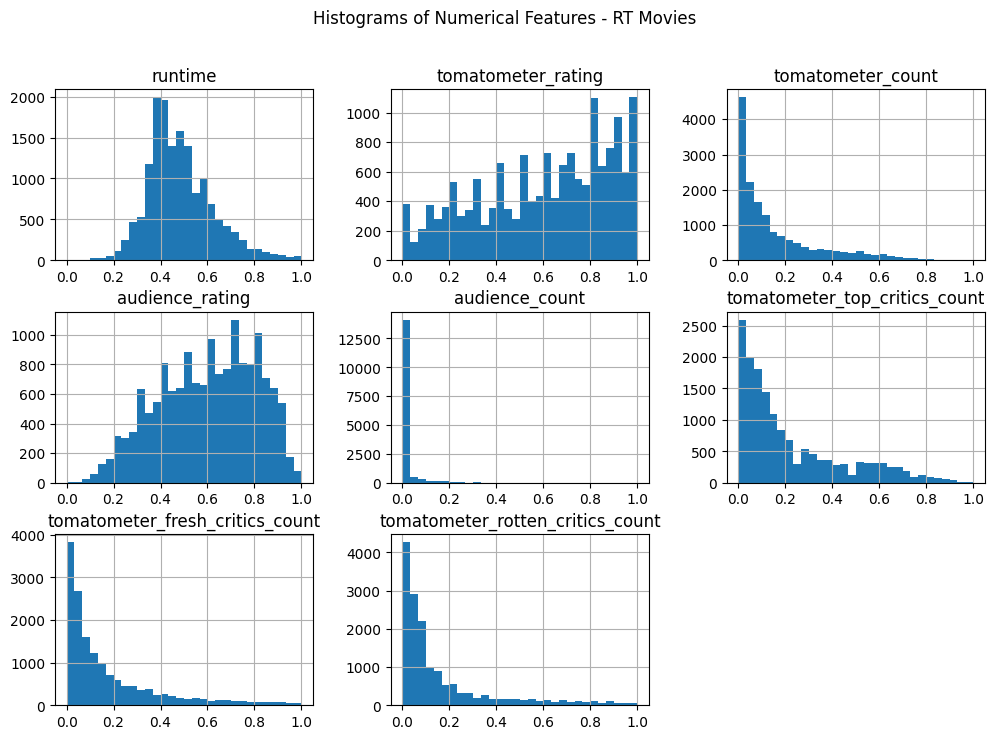

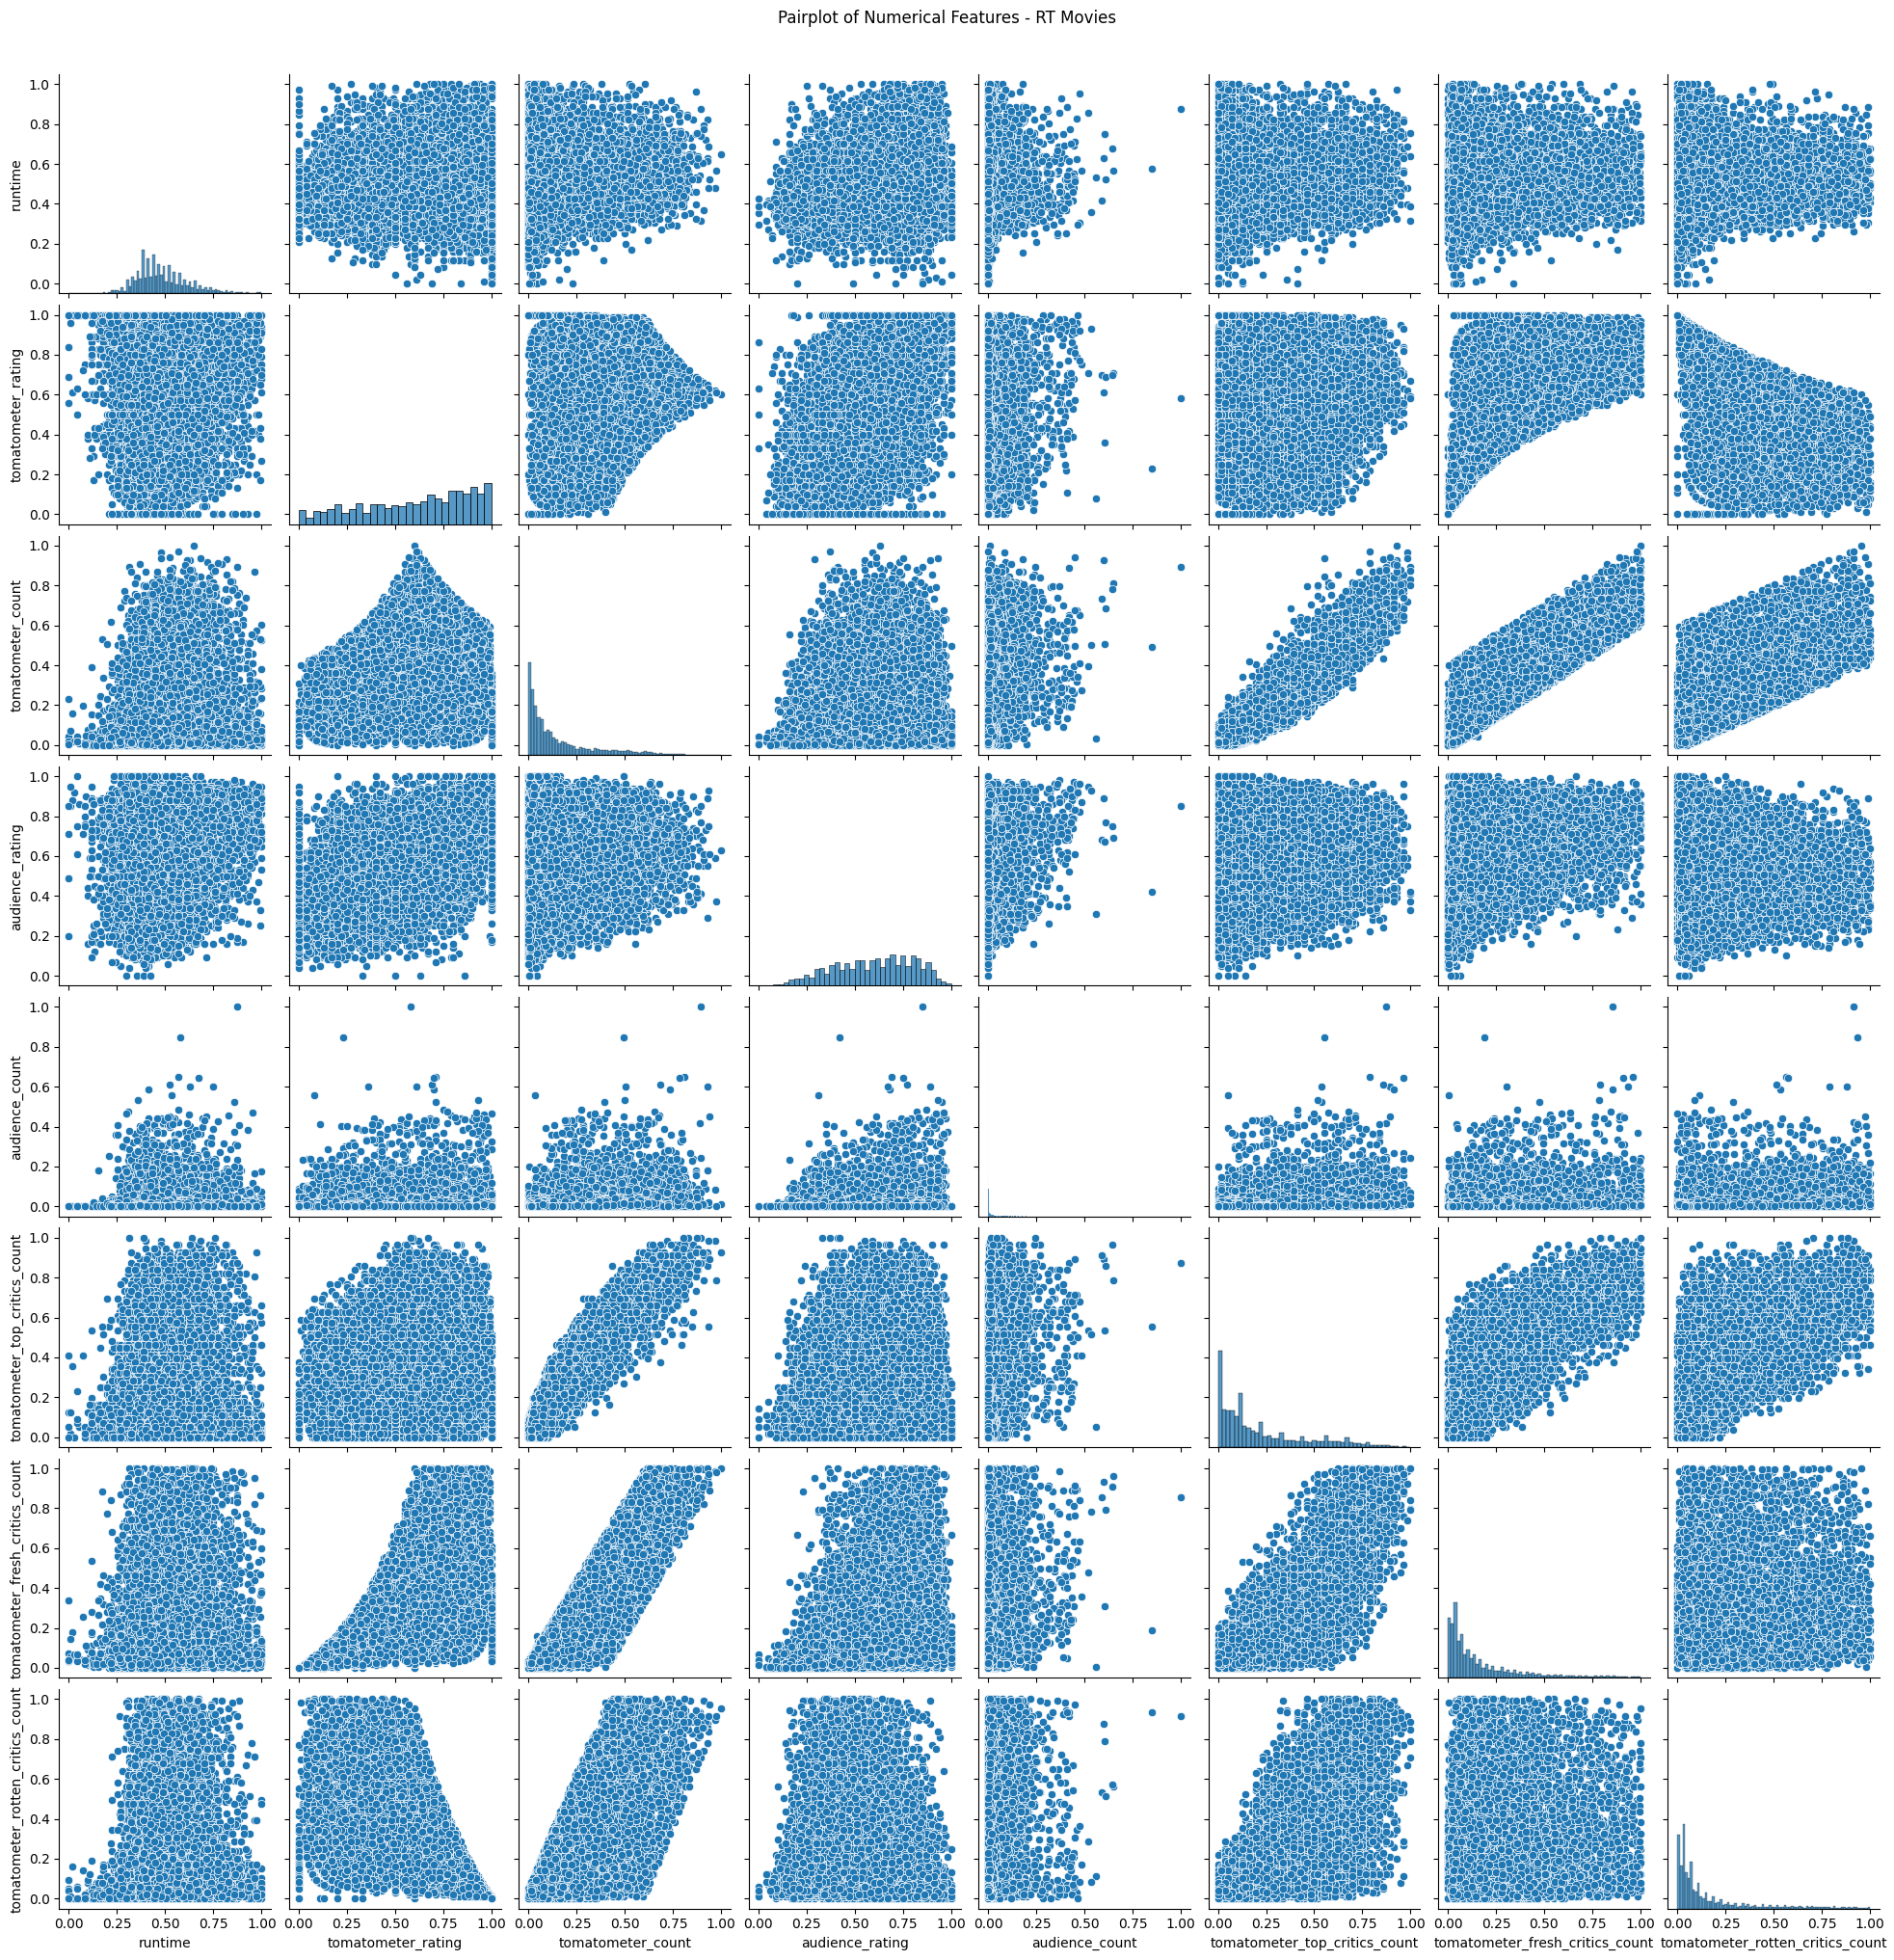

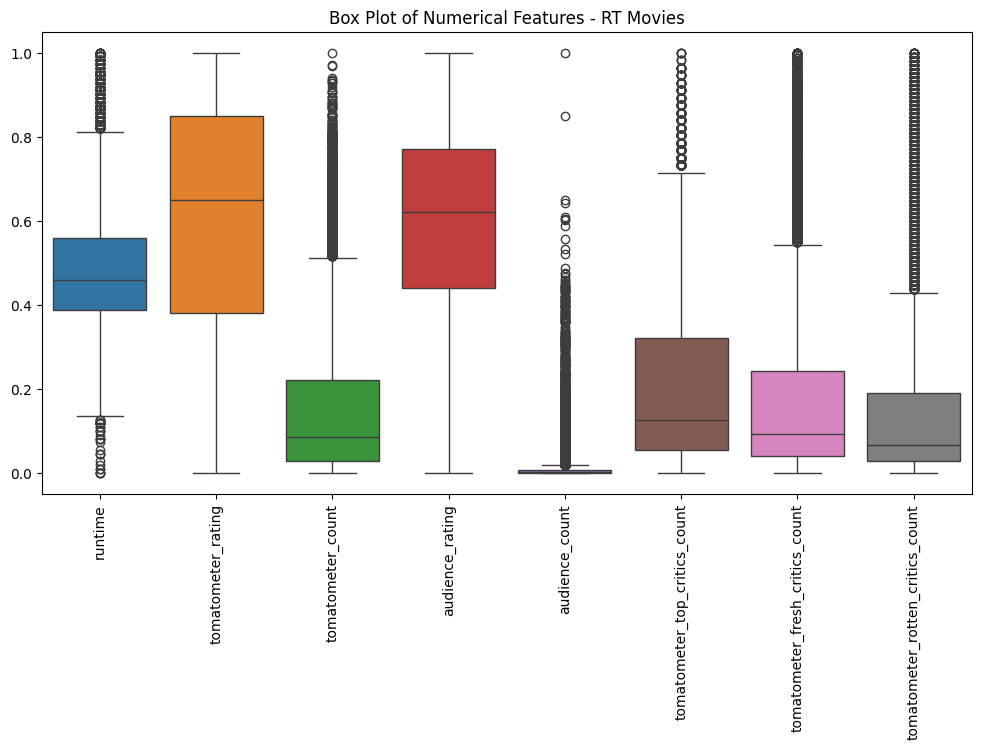

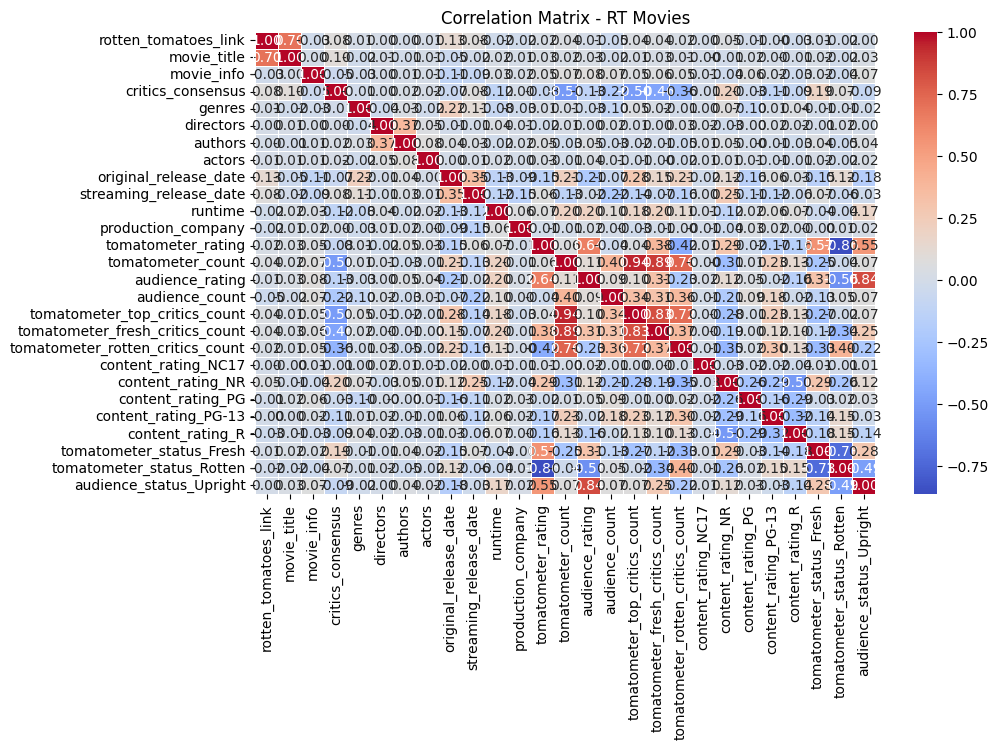

Highly Correlated Features: [('tomatometer_rating', 'tomatometer_status_Rotten'), ('tomatometer_count', 'tomatometer_top_critics_count'), ('tomatometer_count', 'tomatometer_fresh_critics_count'), ('audience_rating', 'audience_status_Upright'), ('tomatometer_top_critics_count', 'tomatometer_count'), ('tomatometer_top_critics_count', 'tomatometer_fresh_critics_count'), ('tomatometer_fresh_critics_count', 'tomatometer_count'), ('tomatometer_fresh_critics_count', 'tomatometer_top_critics_count'), ('tomatometer_status_Rotten', 'tomatometer_rating'), ('audience_status_Upright', 'audience_rating')]
Feature Skewness:
tomatometer_count                   1.555648
audience_count                      6.002626
tomatometer_top_critics_count       1.183614
tomatometer_fresh_critics_count     1.799176
tomatometer_rotten_critics_count    1.999564
dtype: float64


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Display descriptive statistics
print("Descriptive Statistics:")
print(rt_movies.describe())
print(rt_reviews.describe())
print(netflix.describe())
print(imdb.describe())
rt_movies_temp = pd.read_csv("../Data/rotten_tomatoes_movies.csv")

# Histograms for numerical features
numerical_columns = rt_movies_temp.select_dtypes(include=['number']).columns
rt_movies[numerical_columns].hist(figsize=(12, 8), bins=30)
plt.suptitle("Histograms of Numerical Features - RT Movies")
plt.savefig("histograms.png", dpi=300, bbox_inches="tight")
plt.show()

# Scatter plot to check relationships
sns.pairplot(rt_movies[numerical_columns])
plt.suptitle("Pairplot of Numerical Features - RT Movies", y=1.02)
plt.savefig("pairplot.png", dpi=300, bbox_inches="tight")
plt.show()

# Boxplots to detect outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=rt_movies[numerical_columns])
plt.xticks(rotation=90)
plt.title("Box Plot of Numerical Features - RT Movies")
plt.savefig("boxplot.png", dpi=300, bbox_inches="tight")
plt.show()

# Correlation matrix to identify multicollinearity
plt.figure(figsize=(10, 6))
corr_matrix = rt_movies.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix - RT Movies")
plt.savefig("correlation_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

# Detecting highly correlated features
threshold = 0.8
highly_correlated = [(col1, col2) for col1 in corr_matrix.columns for col2 in corr_matrix.columns 
                     if col1 != col2 and abs(corr_matrix.loc[col1, col2]) > threshold]
print("Highly Correlated Features:", highly_correlated)

# Checking skewness of numerical features
skewness = rt_movies[numerical_columns].apply(lambda x: x.skew())
print("Feature Skewness:")
print(skewness[abs(skewness) > 1])  # Display features with high skewness
